In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
title = 'SARIMAX VCB 7-2-1'
train_ratio = 0.7
test_ratio = 0.2
#Mảng chứa giá trị để kiểm tra chu kỳ từ 2 đến 10 ngày (2 tuần)
seasonal_arr = np.array(range(2, 11))
seasonal_arr

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])

In [3]:
df=pd.read_csv('../../VCB Historical Data.csv',index_col='Date',parse_dates=True)
#đảo ngược dữ liệu
df=df.iloc[::-1]

In [4]:
#Thêm tập dữ liệu VN Index
df_vni=pd.read_csv('../../VN Index Historical Data.csv',index_col='Date',parse_dates=True)
df_vni=df_vni.iloc[::-1]

In [5]:
df_vni=df_vni['Price'].replace(',','',regex=True).astype(float)

In [6]:
#Chuyển dữ liệu lần cuối, % thay đổi về dạng int
df=df['Price'].replace(',','',regex=True).astype(float)

In [7]:
#Chia dư liệu thành 2 phần train và test với tỉ lệ 70:30
train_size = int(train_ratio * len(df))
test_size = int(test_ratio * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

vni_train=df_vni[:train_size]
vni_test=df_vni[train_size:train_size+test_size]
vni_val=df_vni[train_size+test_size:]

In [8]:
#Làm hàm cho vào mảng seasonal_arr và chạy qua với auto arima để tìm ra chu kỳ tốt nhất
#Đối với mỗi lần lặp ta sẽ xét xem model nào có chỉ số AIC tốt nhất để lấy
def grid_search(arr):
    best_aic=0
    for i in arr:
        print("Seasonal Period: ",i)
        model=auto_arima(train,exog=vni_train,seasonal=True,m=i, error_action='ignore', suppress_warnings=True)
        print("AIC: ",model.aic())
        print("------------------")
        if model.aic()<best_aic or best_aic==0:
            best_aic=model.aic()
            best_model=model
    return best_model

In [9]:
search=grid_search(seasonal_arr)
search.summary()

Seasonal Period:  2
AIC:  13253.43482287852
------------------
Seasonal Period:  3
AIC:  13047.246247795068
------------------
Seasonal Period:  4
AIC:  13048.953059079493
------------------
Seasonal Period:  5
AIC:  13044.668735797728
------------------
Seasonal Period:  6
AIC:  13049.19871066069
------------------
Seasonal Period:  7
AIC:  13044.965667419536
------------------
Seasonal Period:  8
AIC:  13044.965667419536
------------------
Seasonal Period:  9
AIC:  13049.19871066069
------------------
Seasonal Period:  10
AIC:  13044.965667419536
------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  770
Model:             SARIMAX(2, 1, 2)x(0, 0, 2, 5)   Log Likelihood               -6515.334
Date:                           Sat, 03 Jun 2023   AIC                          13044.669
Time:                                   21:33:46   BIC                          13077.184
Sample:                                        0   HQIC                         13057.183
                                           - 770                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2887      0.032      8.983      0.000       0.226       0.352
ar.L2         -0.9330      0.032    -29.565      0.000      -0.995      -0.871
ma.L1         -0.2667      0.025    -10.544      0.000      -0.316      -0.217
ma.L2          0.9650      0.025     38.740      0.000       0.916       1.014
ma.S.L5        0.0548      0.030      1.819      0.069      -0.004       0.114
ma.S.L10      -0.0301      0.033     -0.915      0.360      -0.095       0.034
sigma2      1.346e+06   4.79e+04     28.066      0.000    1.25e+06    1.44e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):               202.97
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               2.78   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
p,d,q=search.order
P,D,Q,m=search.seasonal_order

In [11]:
model_fit=SARIMAX(endog=train,exog=vni_train, order=(p, d, q), seasonal_order=(P,D,Q,m))
model=model_fit.fit()
print(model.summary())

d:\Software\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Software\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Software\Python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                                     SARIMAX Results                                     
Dep. Variable:                             Price   No. Observations:                  770
Model:             SARIMAX(2, 1, 2)x(0, 0, 2, 5)   Log Likelihood               -6287.174
Date:                           Sat, 03 Jun 2023   AIC                          12590.347
Time:                                   21:33:48   BIC                          12627.508
Sample:                                        0   HQIC                         12604.649
                                           - 770                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Price         61.2929      1.936     31.661      0.000      57.499      65.087
ar.L1          0.9493      0.077     12.347

In [12]:
#Quá trình testing
y_test=np.array(test)
y_pred=model.predict(start=train_size,end=train_size+test_size-1,exog=vni_test)

#Quá trình validate
y_val=np.array(val)
y_pred_val=model.predict(start=train_size,end=train_size+val_size-1,exog=vni_val)

d:\Software\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Software\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


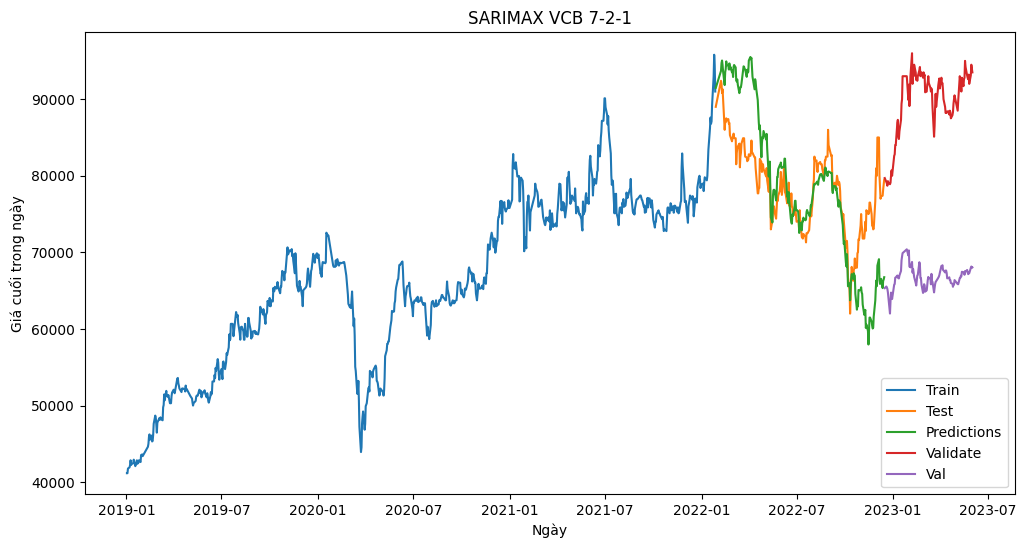

In [13]:
plt.figure(figsize=(12,6))
plt.plot(train)
plt.plot(test)
plt.plot(test.index,y_pred)
plt.plot(val)
plt.plot(val.index, y_pred_val)
#plt.plot(y_next_30_days)
plt.title('SARIMAX Forecast')
plt.xlabel('Ngày')
plt.ylabel('Giá cuối trong ngày')
plt.title(title)
#plt.legend(['Train', 'Test', 'Predictions','Validate','Val','Next 30 days'], loc='lower right')
plt.legend(['Train', 'Test', 'Predictions','Validate','Val'], loc='lower right')

In [14]:
#Các chỉ số Đánh giá 
def deviation(test, pred):
  rmse=np.sqrt(mean_squared_error(test,pred))
  print(f"RMSE: {rmse:.2f}")
  mape=mean_absolute_percentage_error(test,pred)
  print(f"MAPE: {mape*100:.2f}%")
  mae = mean_absolute_error(test, pred)
  print(f"MAE: {mae:.2f}")

In [15]:
deviation(y_test,y_pred)
deviation(y_val,y_pred_val)

RMSE: 7051.56
MAPE: 6.70%
MAE: 5299.25
RMSE: 23255.97
MAPE: 25.46%
MAE: 22957.19
